## Analyze model redundancy

In [42]:
import sys
sys.path.append("..")

import tensorflow as tf
import numpy as np

from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import data_dir, model_dir

In [2]:
task_name = "scalar1"

In [3]:
## LOAD DATA (~40 sec)
particles = ["pi0", "gamma", task_name]
clouds = []
for particle in particles:
    print(f"Loading 10% of data for particle {particle}...")
    clouds.append(np.load(f"{data_dir}/processed/{particle}_cloud.npy")[::10])
clouds = np.vstack(clouds)
print(f"clouds.shape: {clouds.shape}")

Loading 10% of data for particle pi0...
Loading 10% of data for particle gamma...
Loading 10% of data for particle scalar1...
clouds.shape: (30000, 960, 4)


In [44]:
# Further sample
clouds_samp = clouds[::10]
print(clouds_samp.shape)

(3000, 960, 4)


In [45]:
model = tf.keras.models.load_model(f"{model_dir}/{task_name}_pfn")

In [46]:
print(f"Running cloud through first layer...")
raw_units = model.layers[0](clouds_samp)
all_units = {}

for i, layer in enumerate(model.layers[1:]):
    print(f"Running units through layer {i} ({layer.name})...", end="")
    if "Sigma" in layer.name:
        raw_units = tf.math.reduce_sum(raw_units, axis=1, name="Sigma")
    else:
        raw_units = layer(raw_units)
    print(f"  raw_units.shape: {raw_units.shape}", end="")
    
    # Reshapoe if necessary
    if "Phi" in layer.name:
        units = raw_units.numpy().reshape((-1, raw_units.shape[-1]))
    else:
        units = raw_units.numpy()
    print(f"  units.shape: {units.shape}")
    all_units[layer.name] = units

Running cloud through first layer...
Running units through layer 0 (masking)...  raw_units.shape: (3000, 960, 4)  units.shape: (3000, 960, 4)
Running units through layer 1 (Phi_0)...

2023-11-05 01:00:51.798751: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2949120000 exceeds 10% of free system memory.
2023-11-05 01:00:52.078487: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2949120000 exceeds 10% of free system memory.
2023-11-05 01:00:52.524244: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2949120000 exceeds 10% of free system memory.


  raw_units.shape: (3000, 960, 256)  units.shape: (2880000, 256)
Running units through layer 2 (Phi_1)...

2023-11-05 01:00:54.223930: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2949120000 exceeds 10% of free system memory.
2023-11-05 01:00:55.659746: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2949120000 exceeds 10% of free system memory.


  raw_units.shape: (3000, 960, 256)  units.shape: (2880000, 256)
Running units through layer 3 (Phi_2)...  raw_units.shape: (3000, 960, 256)  units.shape: (2880000, 256)
Running units through layer 4 (Phi_3)...  raw_units.shape: (3000, 960, 256)  units.shape: (2880000, 256)
Running units through layer 5 (Phi_4)...  raw_units.shape: (3000, 960, 128)  units.shape: (2880000, 128)
Running units through layer 6 (Phi_5)...  raw_units.shape: (3000, 960, 128)  units.shape: (2880000, 128)
Running units through layer 7 (Phi_6)...  raw_units.shape: (3000, 960, 128)  units.shape: (2880000, 128)
Running units through layer 8 (Phi_7)...  raw_units.shape: (3000, 960, 128)  units.shape: (2880000, 128)
Running units through layer 9 (Sigma)...  raw_units.shape: (3000, 128)  units.shape: (3000, 128)
Running units through layer 10 (F_0)...  raw_units.shape: (3000, 256)  units.shape: (3000, 256)
Running units through layer 11 (F_1)...  raw_units.shape: (3000, 256)  units.shape: (3000, 256)
Running units th

In [47]:
for name, units in all_units.items():
    print(f"{name:<15} {units.shape}")

masking         (3000, 960, 4)
Phi_0           (2880000, 256)
Phi_1           (2880000, 256)
Phi_2           (2880000, 256)
Phi_3           (2880000, 256)
Phi_4           (2880000, 128)
Phi_5           (2880000, 128)
Phi_6           (2880000, 128)
Phi_7           (2880000, 128)
Sigma           (3000, 128)
F_0             (3000, 256)
F_1             (3000, 256)
F_2             (3000, 256)
F_3             (3000, 256)
F_4             (3000, 128)
F_5             (3000, 128)
F_6             (3000, 128)
F_7             (3000, 128)
output          (3000, 3)


Phi_0           (2880000, 256)


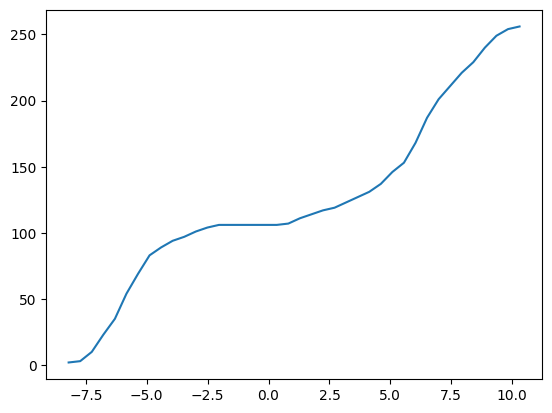

In [48]:
for name, units in all_units.items():
    if name == "masking": continue
    print(f"{name:<15} {units.shape}")
    
    values, base = np.histogram(np.log(np.var(units, axis=0)), bins=40)
    plt.plot(base[:-1], np.cumsum(values))
    
    break

In [50]:
table = []

for name, units in tqdm(all_units.items()):
    if name == "masking": continue    
    zero_var = np.where(np.var(units, axis=0) == 0)[0]
    table.append([name, units.shape[1], len(zero_var), units.shape[1] - len(zero_var)])

print(f"{task_name} PFN, unit redundancy analysis on {len(clouds_samp)} jets")
print(tabulate(table, headers=["layer", "n_units", "# units no variance", "# units useful"]))

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]

scalar1 PFN, unit redundancy analysis on 3000 jets
layer      n_units    # units no variance    # units useful
-------  ---------  ---------------------  ----------------
Phi_0          256                      0               256
Phi_1          256                    103               153
Phi_2          256                     12               244
Phi_3          256                     33               223
Phi_4          128                     19               109
Phi_5          128                     13               115
Phi_6          128                     11               117
Phi_7          128                     15               113
Sigma          128                     15               113
F_0            256                    115               141
F_1            256                     72               184
F_2            256                     26               230
F_3            256                     14               242
F_4            128                      6        

In [ ]:
units

In [ ]:
plt.imshow(np.log(units[0] + 1e-9))